# Race Trace for Formula One 2019 Season

We first look at the overall standings at the end of the season<br>
Then we move on to individual races of the season

In [53]:
YEAR = 2019
#            HAM,BOT,  VET, LEC, VER,   ALB,  SAI,  NOR,  HUL,  RIC,  RAI, GIO, GAS,  KVY,  GRO,  MAG,  KUB, RUS, PER,  STR
DRIVER_LS = {1:0,822:1,20:0,844:1,830:0,848:1,832:0,846:1,807:1,817:0,8:0,841:1,842:0,826:1,154:1,825:0,9:0,847:1,815:1,840:0}
DRIVER_C = {1:"#00CACA",822:"#00CACA",20:"#FF0000",844:"#FF0000",830:"#0000B0",848:"#0000B0",832:"#FE7F00",846:"#FE7F00",
    807:"#f0d405",817:"#f0d405",8:"#420404",841:"#420404",842:"#030438",826:"#030438",154:"#191919",825:"#191919",9:"#dfebe9",
    847:"#dfebe9",815:"#ed0e89",840:"#ed0e89"
}
#DRIVER_C = {1:"#00CACA",4:"#7F7F7F",8:"#FF0000",13:"#007FFE",18:"#7F7F7F",20:"#FF0000",154:"#191919",807:"#7C7C00",814:"#007FFE",815:"#FE7F00",817:"#0000B0",822:"#00CACA",825:"#191919",826:"#7B68EE",828:"#003B76",830:"#0000B0",832:"#7B68EE",835:"#7C7C00",836:"#003B76",838:"#7F7F7F",839:"#FE7F00",840:"#007FFE",841:"#003B76",842:"#7B68EE",843:"#7B68EE"}
LINESTYLES = ['-', '-.', '--', ':', '-', '-']

In [54]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import urllib

# def read_csv(name, **kwargs):
#     df = pd.read_csv(f'', **kwargs)
#     return df

# Read data
circuits = pd.read_csv('Dataset/circuits.csv', index_col=0)
constructorResults = pd.read_csv('Dataset/constructor_results.csv', index_col=0)
constructors = pd.read_csv('Dataset/constructors.csv', index_col=0)
constructorStandings = pd.read_csv('Dataset/constructor_standings.csv', index_col=0)
drivers = pd.read_csv('Dataset/drivers.csv', encoding='cp858', index_col=0)
driverStandings = pd.read_csv('Dataset/driver_standings.csv', index_col=0)
lapTimes = pd.read_csv('Dataset/lap_times.csv')
pitStops = pd.read_csv('Dataset/pit_stops.csv')
qualifying = pd.read_csv('Dataset/qualifying.csv', index_col=0)
races = pd.read_csv('Dataset/races.csv', index_col=0)
results = pd.read_csv('Dataset/results.csv', index_col=0)
seasons = pd.read_csv('Dataset/seasons.csv', index_col=0)
status = pd.read_csv('Dataset/status.csv', index_col=0)

# Join fields
results['status'] = results.statusId.map(status.status)
results['Team'] = results.constructorId.map(constructors.name)

def url_extract(s):
    return (s.str.split('/') 
             .str[-1].fillna('') 
             .apply(urllib.parse.unquote) 
             .str.replace('_', ' ') 
             .str.replace('\s*\(.*\)', ''))

# Fix circuit data
idx = circuits.url.str.contains('%').fillna(False)
circuits.loc[idx, 'name'] = url_extract(circuits[idx].url)
circuits.location.replace({ 'Montmel╠_':'Montmeló',
                            'S╠úo Paulo':'São Paulo',
                            'N╠_rburg':'Nürburg'}, inplace=True)

# Fix driver data
idx = drivers.url.str.contains('%').fillna(False)
t = url_extract(drivers.url)
drivers.loc[idx, 'forename'] = t[idx].str.split(' ').str[0]
drivers.loc[idx, 'surname'] = t[idx].str.split(' ').str[1:].str.join(' ')

# Fix original CSV (not caused by the above code!)
drivers.loc[31, 'forename'] = 'Juan Pablo'
drivers.loc[31, 'surname'] = 'Montoya'

idx = drivers.surname.str.contains('Schumacher').fillna(False)
drivers['display'] = drivers.surname
drivers.loc[idx, 'display'] = drivers.loc[idx, 'forename'].str[0] + ". " + drivers.loc[idx, 'surname']

# For display in HTML tables
drivers['Driver'] = drivers['forename'] + " " + drivers['surname']

In [55]:
results['position'].replace(r'\N',np.nan,inplace = True)

In [56]:
# Cut data to one year
races = races.query('year==@YEAR').sort_values('round').copy()
results = results[results.raceId.isin(races.index)].copy()
lapTimes = lapTimes[lapTimes.raceId.isin(races.index)].copy()
driverStandings = driverStandings[driverStandings.raceId.isin(races.index)].copy()
driverStandings['round'] = driverStandings.raceId.map(races['round'])
driverStandings['round'] -= driverStandings['round'].min()
driverStandings = driverStandings.set_index('round').sort_index()

In [57]:
def format_standings(df):
    df = df.join(drivers.drop('number', 1))
    df = df.sort_values('position')
    dc = results.groupby('driverId').Team.value_counts()
    drv = dc.to_frame('count').reset_index().drop_duplicates(subset=['driverId']).set_index('driverId')
    s = results.assign(score=results.points>0).groupby('driverId').score.sum()
    p = results.assign(podium=results.position.astype('float64')<=3).groupby('driverId').podium.sum()
    df['Team'] = df.index.map(drv.Team)
    df['Position'] = df.positionText
    df['points'] = df.points.map(int)
    df['scores'] = df.index.map(s)
    df['podiums'] = df.index.map(p)
    df.loc[df.scores <= 0, 'scores'] = ''
    df.loc[df.points <= 0, 'points'] = ''
    df.loc[df.podiums <= 0, 'podiums'] = ''
    df.loc[df.wins <= 0, 'wins'] = ''
    use = ['Driver', 'Position', 'points', 'wins', 'podiums', 'scores', 'nationality', 'Team' ]
    df = df[use].set_index('Position').fillna('')
    df.columns = df.columns.str.capitalize()
    return df

def format_results(df):
    df = df.join(drivers.drop('number', 1))
    df['Team'] = df.constructorId.map(constructors.name)
    df['Position'] = df.positionOrder
    df['number'] = df.number.map(int)
    df['points'] = df.points.map(int)
    df.loc[df.points <= 0, 'points'] = ''
    use = ['Driver', 'Team', 'number', 'grid', 'Position', 'points', 'laps', 'time', 'status' ]
    df = df[use].set_index('Position').fillna('')
    df.columns = df.columns.str.capitalize()
    return df

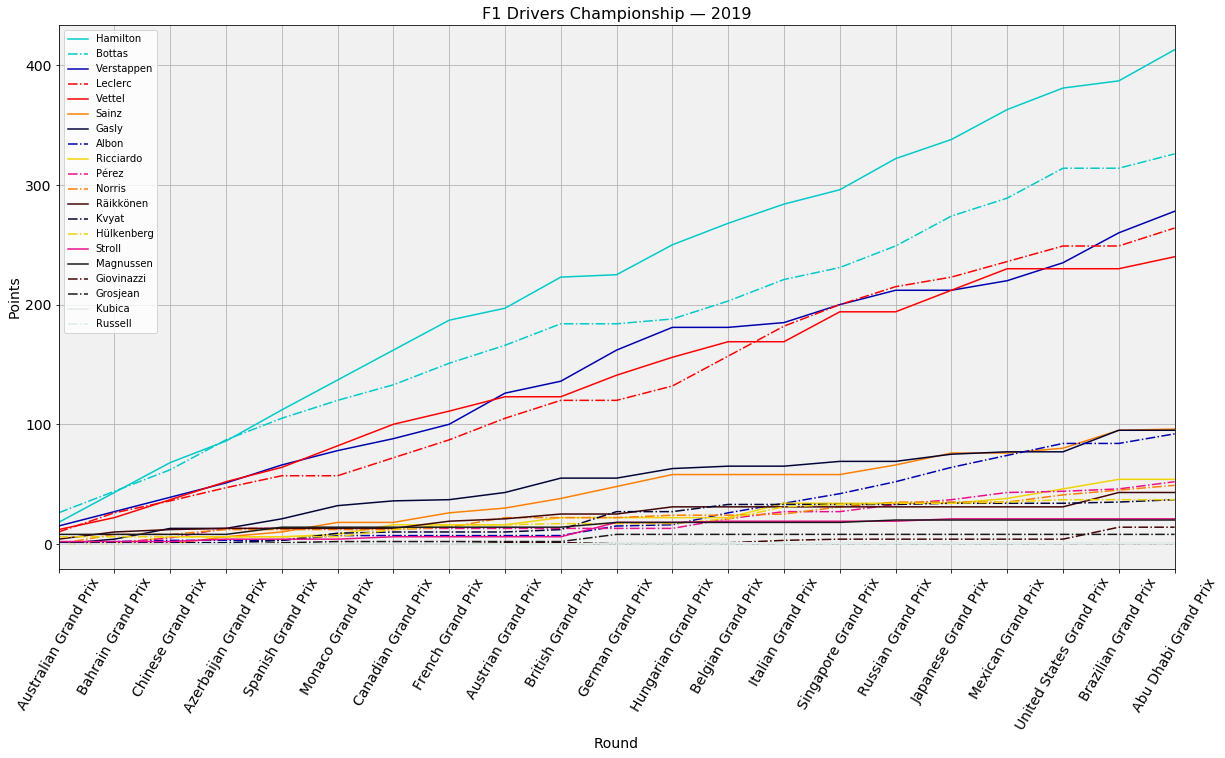

Driver Points Wins Podiums Scores Nationality  \
Position                                                              
1             Lewis Hamilton    413   11      17     21     British   
2            Valtteri Bottas    326    4      15     19     Finnish   
3             Max Verstappen    278    3       9     19       Dutch   
4            Charles Leclerc    264    2      10     18  Monegasque   
5           Sebastian Vettel    240    1       9     16      German   
6               Carlos Sainz     96            1     13     Spanish   
7               Pierre Gasly     95            1     14      French   
8            Alexander Albon     92                  13        Thai   
9           Daniel Ricciardo     54                   8  Australian   
10              Sergio Pérez     52                  11     Mexican   
11              Lando Norris     49                  11     British   
12            Kimi Räikkönen     43                   9     Finnish   
13              Daniil Kvyat     37            1     10     Russian   
14           Nico Hülkenberg     37                  10      German   
15              Lance Stroll     21                   6    Canadian   
16           Kevin Magnussen     20                   4      Danish   
17        Antonio Giovinazzi     14                   4     Italian   
18           Romain Grosjean      8                   3      French   
19             Robert Kubica      1                   1      Polish   
20            George Russell                                British   

                  Team  
Position                
1             Mercedes  
2             Mercedes  
3             Red Bull  
4              Ferrari  
5              Ferrari  
6              McLaren  
7             Red Bull  
8           Toro Rosso  
9              Renault  
10        Racing Point  
11             McLaren  
12          Alfa Romeo  
13          Toro Rosso  
14             Renault  
15        Racing Point  
16        Haas F1 Team  
17          Alfa Romeo  
18        Haas F1 Team  
19            Williams  
20            Williams

In [58]:
display(HTML(
    f'<h1 id="champ">Formula One Drivers Championship &mdash; {YEAR}</h1>'
))

# Championship position traces
traces = [(df.position.iloc[-1], d, df) for d, df in driverStandings.groupby('driverId')]

# Show championship traces
for _, d, df in sorted(traces):
    ser = df.points
    ser.name = drivers.display[d]
    ax = ser.plot(figsize=(20, 10),
                  fontsize=14,
                  linestyle=LINESTYLES[DRIVER_LS[d]],
                  xticks=races['round'].values - 1,
                  color=DRIVER_C[d],
                  grid=True,
                  legend=True)

ax.set_title(f'F1 Drivers Championship — {YEAR}', fontsize=16)
ax.set_facecolor('#f1f1f1')
ax.set_ylabel('Points', fontsize=14)
ax.set_xlabel('Round', fontsize=14)
ax.set_xticklabels(races['name'].values, rotation=60)
plt.show()

display(format_standings(driverStandings[driverStandings.raceId==driverStandings.raceId.max()].set_index('driverId')))

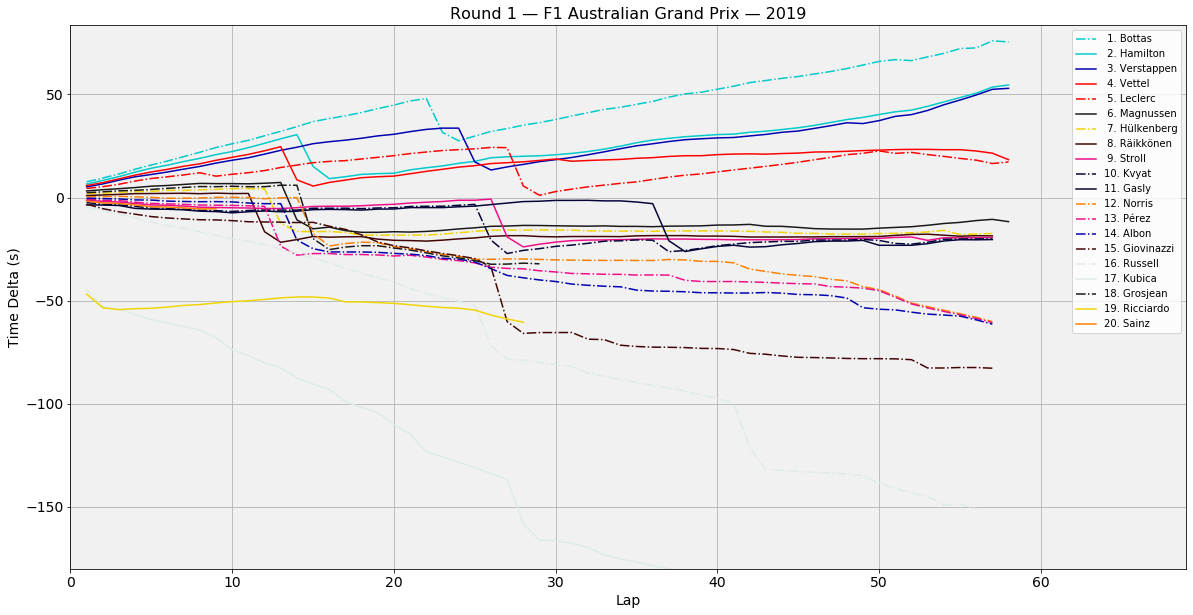

Driver          Team  Number  Grid Points  Laps  \
Position                                                                
1            Valtteri Bottas      Mercedes      77     2     26    58   
2             Lewis Hamilton      Mercedes      44     1     18    58   
3             Max Verstappen      Red Bull      33     4     15    58   
4           Sebastian Vettel       Ferrari       5     3     12    58   
5            Charles Leclerc       Ferrari      16     5     10    58   
6            Kevin Magnussen  Haas F1 Team      20     7      8    58   
7            Nico Hülkenberg       Renault      27    11      6    57   
8             Kimi Räikkönen    Alfa Romeo       7     9      4    57   
9               Lance Stroll  Racing Point      18    16      2    57   
10              Daniil Kvyat    Toro Rosso      26    15      1    57   
11              Pierre Gasly      Red Bull      10    17           57   
12              Lando Norris       McLaren       4     8           57   
13              Sergio Pérez  Racing Point      11    10           57   
14           Alexander Albon    Toro Rosso      23    13           57   
15        Antonio Giovinazzi    Alfa Romeo      99    14           57   
16            George Russell      Williams      63    19           56   
17             Robert Kubica      Williams      88    20           55   
18           Romain Grosjean  Haas F1 Team       8     6           29   
19          Daniel Ricciardo       Renault       3    12           28   
20              Carlos Sainz       McLaren      55    18            9   

                 Time    Status  
Position                         
1         1:25:27.325  Finished  
2             +20.886  Finished  
3             +22.520  Finished  
4             +57.109  Finished  
5             +58.203  Finished  
6           +1:27.156  Finished  
7                  \N    +1 Lap  
8                  \N    +1 Lap  
9                  \N    +1 Lap  
10                 \N    +1 Lap  
11                 \N    +1 Lap  
12                 \N    +1 Lap  
13                 \N    +1 Lap  
14                 \N    +1 Lap  
15                 \N    +1 Lap  
16                 \N   +2 Laps  
17                 \N   +3 Laps  
18                 \N     Wheel  
19                 \N    Damage  
20                 \N    Engine

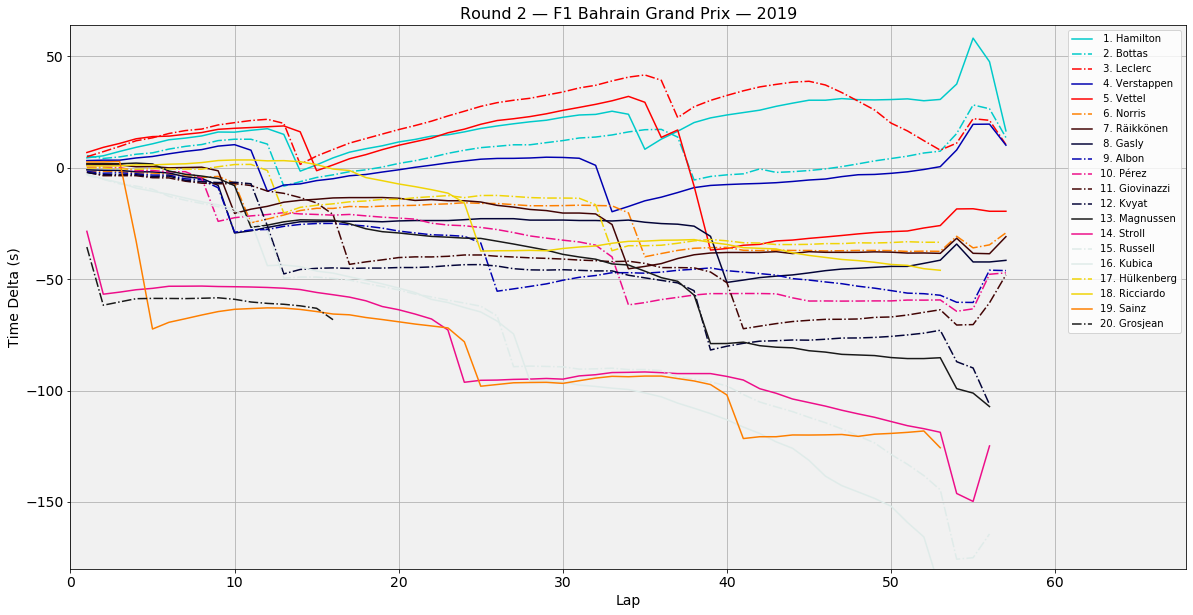

Driver          Team  Number  Grid Points  Laps  \
Position                                                                
1             Lewis Hamilton      Mercedes      44     3     25    57   
2            Valtteri Bottas      Mercedes      77     4     18    57   
3            Charles Leclerc       Ferrari      16     1     16    57   
4             Max Verstappen      Red Bull      33     5     12    57   
5           Sebastian Vettel       Ferrari       5     2     10    57   
6               Lando Norris       McLaren       4     9      8    57   
7             Kimi Räikkönen    Alfa Romeo       7     8      6    57   
8               Pierre Gasly      Red Bull      10    13      4    57   
9            Alexander Albon    Toro Rosso      23    12      2    57   
10              Sergio Pérez  Racing Point      11    14      1    57   
11        Antonio Giovinazzi    Alfa Romeo      99    16           57   
12              Daniil Kvyat    Toro Rosso      26    15           56   
13           Kevin Magnussen  Haas F1 Team      20     6           56   
14              Lance Stroll  Racing Point      18    18           56   
15            George Russell      Williams      63    19           56   
16             Robert Kubica      Williams      88    20           55   
17           Nico Hülkenberg       Renault      27    17           53   
18          Daniel Ricciardo       Renault       3    10           53   
19              Carlos Sainz       McLaren      55     7           53   
20           Romain Grosjean  Haas F1 Team       8    11           16   

                 Time            Status  
Position                                 
1         1:34:21.295          Finished  
2              +2.980          Finished  
3              +6.131          Finished  
4              +6.408          Finished  
5             +36.068          Finished  
6             +45.754          Finished  
7             +47.470          Finished  
8             +58.094          Finished  
9           +1:02.697          Finished  
10          +1:03.696          Finished  
11          +1:04.599          Finished  
12                 \N            +1 Lap  
13                 \N            +1 Lap  
14                 \N            +1 Lap  
15                 \N            +1 Lap  
16                 \N           +2 Laps  
17                 \N            Engine  
18                 \N       Out of fuel  
19                 \N  Collision damage  
20                 \N           Retired

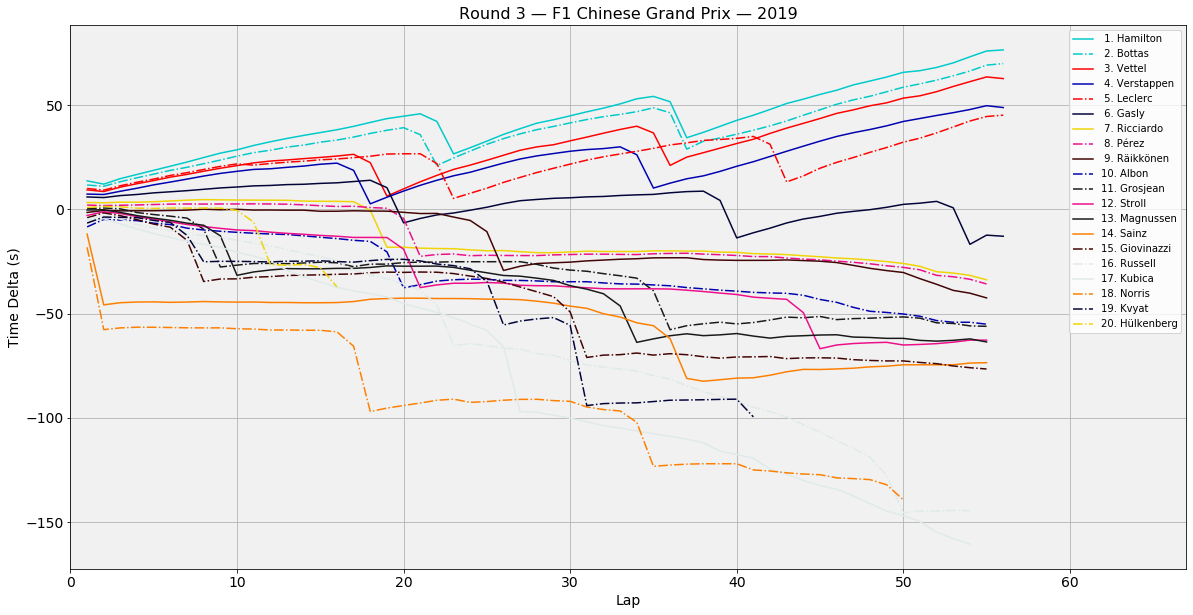

Driver          Team  Number  Grid Points  Laps  \
Position                                                                
1             Lewis Hamilton      Mercedes      44     2     25    56   
2            Valtteri Bottas      Mercedes      77     1     18    56   
3           Sebastian Vettel       Ferrari       5     3     15    56   
4             Max Verstappen      Red Bull      33     5     12    56   
5            Charles Leclerc       Ferrari      16     4     10    56   
6               Pierre Gasly      Red Bull      10     6      9    56   
7           Daniel Ricciardo       Renault       3     7      6    55   
8               Sergio Pérez  Racing Point      11    12      4    55   
9             Kimi Räikkönen    Alfa Romeo       7    13      2    55   
10           Alexander Albon    Toro Rosso      23     0      1    55   
11           Romain Grosjean  Haas F1 Team       8    10           55   
12              Lance Stroll  Racing Point      18    16           55   
13           Kevin Magnussen  Haas F1 Team      20     9           55   
14              Carlos Sainz       McLaren      55    14           55   
15        Antonio Giovinazzi    Alfa Romeo      99    19           55   
16            George Russell      Williams      63    17           54   
17             Robert Kubica      Williams      88    18           54   
18              Lando Norris       McLaren       4    15           50   
19              Daniil Kvyat    Toro Rosso      26    11           41   
20           Nico Hülkenberg       Renault      27     8           16   

                 Time      Status  
Position                           
1         1:32:06.350    Finished  
2              +6.552    Finished  
3             +13.774    Finished  
4             +27.627    Finished  
5             +31.276    Finished  
6           +1:29.307    Finished  
7                  \N      +1 Lap  
8                  \N      +1 Lap  
9                  \N      +1 Lap  
10                 \N      +1 Lap  
11                 \N      +1 Lap  
12                 \N      +1 Lap  
13                 \N      +1 Lap  
14                 \N      +1 Lap  
15                 \N      +1 Lap  
16                 \N     +2 Laps  
17                 \N     +2 Laps  
18                 \N   Collision  
19                 \N   Collision  
20                 \N  Power Unit

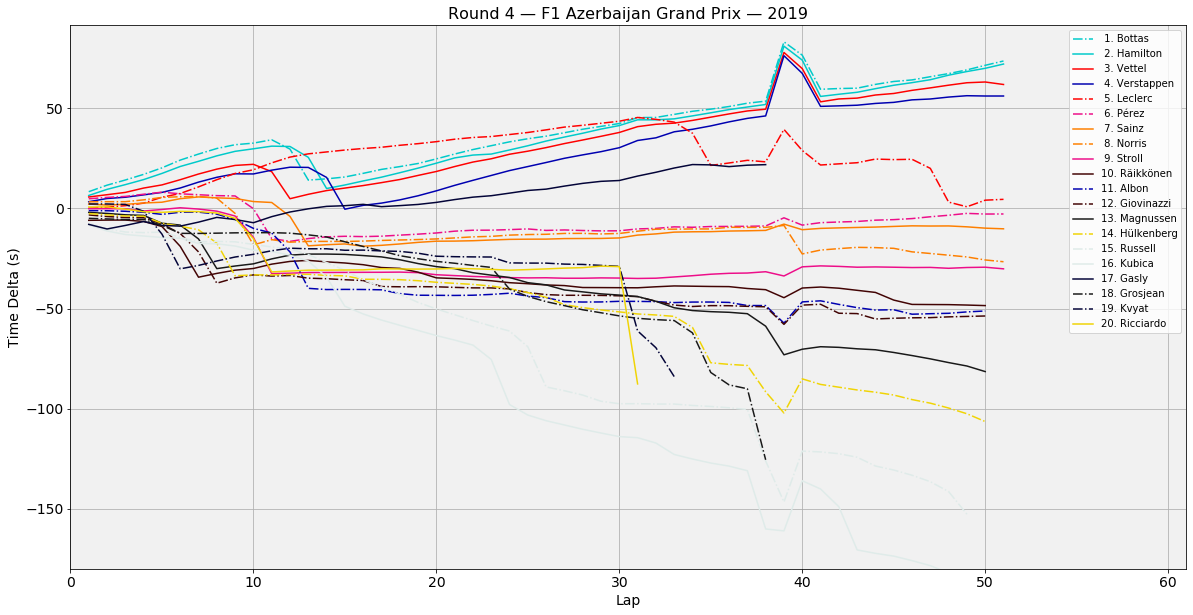

Driver          Team  Number  Grid Points  Laps  \
Position                                                                
1            Valtteri Bottas      Mercedes      77     1     25    51   
2             Lewis Hamilton      Mercedes      44     2     18    51   
3           Sebastian Vettel       Ferrari       5     3     15    51   
4             Max Verstappen      Red Bull      33     4     12    51   
5            Charles Leclerc       Ferrari      16     8     11    51   
6               Sergio Pérez  Racing Point      11     5      8    51   
7               Carlos Sainz       McLaren      55     9      6    51   
8               Lando Norris       McLaren       4     7      4    51   
9               Lance Stroll  Racing Point      18    13      2    51   
10            Kimi Räikkönen    Alfa Romeo       7     0      1    50   
11           Alexander Albon    Toro Rosso      23    11           50   
12        Antonio Giovinazzi    Alfa Romeo      99    17           50   
13           Kevin Magnussen  Haas F1 Team      20    12           50   
14           Nico Hülkenberg       Renault      27    15           50   
15            George Russell      Williams      63    16           49   
16             Robert Kubica      Williams      88     0           49   
17              Pierre Gasly      Red Bull      10     0           38   
18           Romain Grosjean  Haas F1 Team       8    14           38   
19              Daniil Kvyat    Toro Rosso      26     6           33   
20          Daniel Ricciardo       Renault       3    10           31   

                 Time        Status  
Position                             
1         1:31:52.942      Finished  
2              +1.524      Finished  
3             +11.739      Finished  
4             +17.493      Finished  
5           +1:09.107      Finished  
6           +1:16.416      Finished  
7           +1:23.826      Finished  
8           +1:40.268      Finished  
9           +1:43.816      Finished  
10                 \N        +1 Lap  
11                 \N        +1 Lap  
12                 \N        +1 Lap  
13                 \N        +1 Lap  
14                 \N        +1 Lap  
15                 \N       +2 Laps  
16                 \N       +2 Laps  
17                 \N  Transmission  
18                 \N        Brakes  
19                 \N     Collision  
20                 \N     Collision

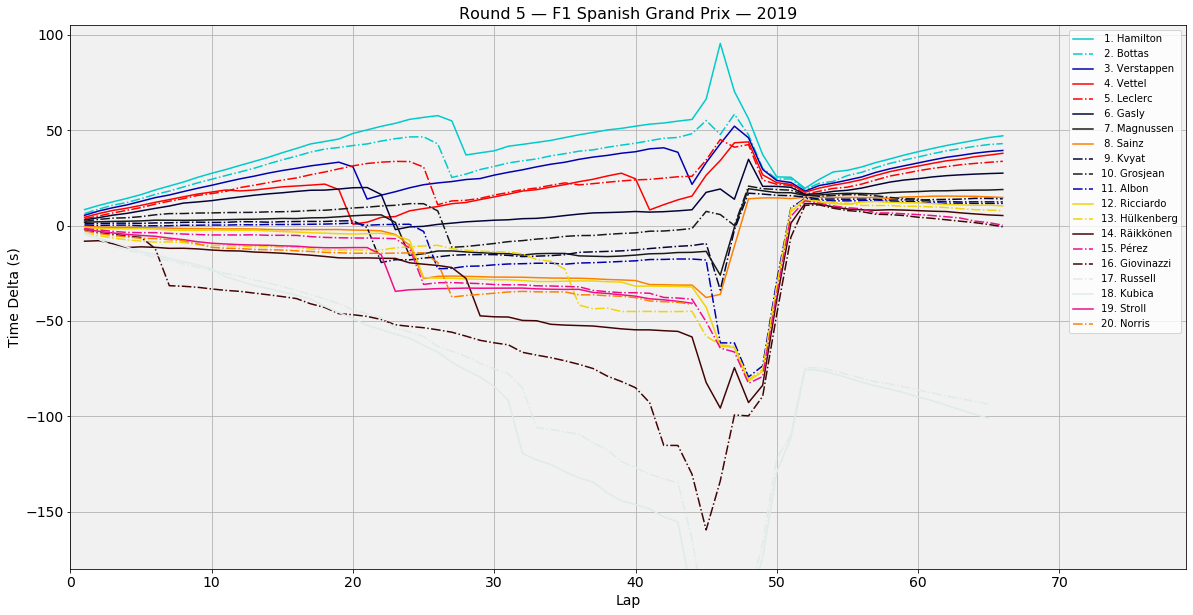

Driver          Team  Number  Grid Points  Laps  \
Position                                                                
1             Lewis Hamilton      Mercedes      44     2     26    66   
2            Valtteri Bottas      Mercedes      77     1     18    66   
3             Max Verstappen      Red Bull      33     4     15    66   
4           Sebastian Vettel       Ferrari       5     3     12    66   
5            Charles Leclerc       Ferrari      16     5     10    66   
6               Pierre Gasly      Red Bull      10     6      8    66   
7            Kevin Magnussen  Haas F1 Team      20     8      6    66   
8               Carlos Sainz       McLaren      55    12      4    66   
9               Daniil Kvyat    Toro Rosso      26     9      2    66   
10           Romain Grosjean  Haas F1 Team       8     7      1    66   
11           Alexander Albon    Toro Rosso      23    11           66   
12          Daniel Ricciardo       Renault       3    13           66   
13           Nico Hülkenberg       Renault      27     0           66   
14            Kimi Räikkönen    Alfa Romeo       7    14           66   
15              Sergio Pérez  Racing Point      11    15           66   
16        Antonio Giovinazzi    Alfa Romeo      99    18           66   
17            George Russell      Williams      63    19           65   
18             Robert Kubica      Williams      88    17           65   
19              Lance Stroll  Racing Point      18    16           44   
20              Lando Norris       McLaren       4    10           44   

                 Time     Status  
Position                          
1         1:35:50.443   Finished  
2              +4.074   Finished  
3              +7.679   Finished  
4              +9.167   Finished  
5             +13.361   Finished  
6             +19.576   Finished  
7             +28.159   Finished  
8             +32.342   Finished  
9             +33.056   Finished  
10            +34.641   Finished  
11            +35.445   Finished  
12            +36.758   Finished  
13            +39.241   Finished  
14            +41.803   Finished  
15            +46.877   Finished  
16            +47.691   Finished  
17                 \N     +1 Lap  
18                 \N     +1 Lap  
19                 \N  Collision  
20                 \N  Collision

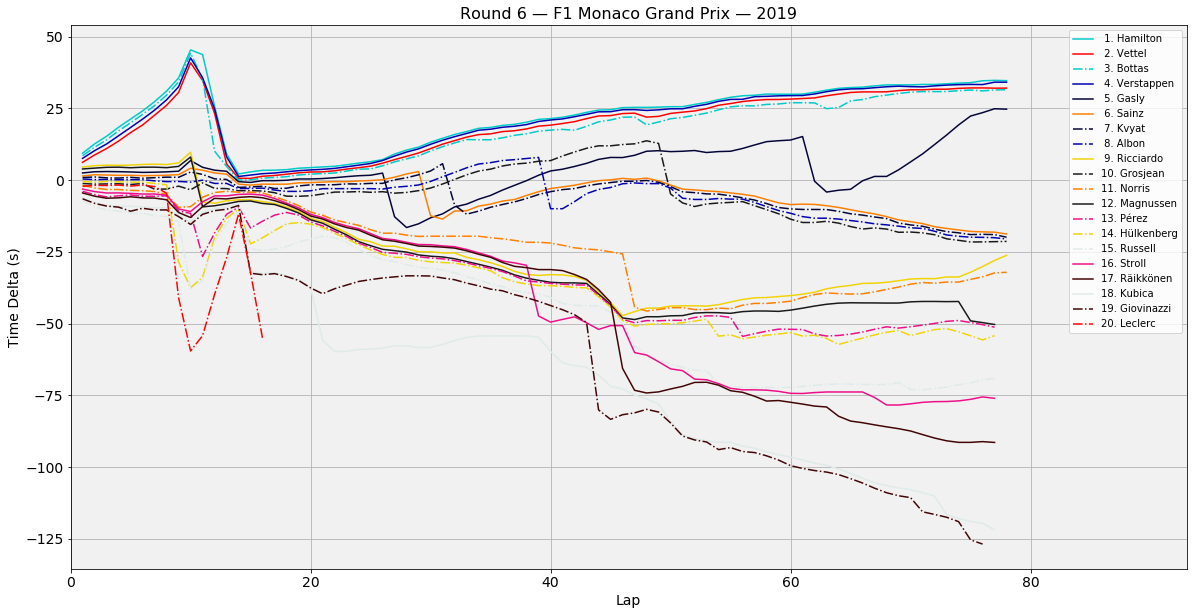

Driver          Team  Number  Grid Points  Laps  \
Position                                                                
1             Lewis Hamilton      Mercedes      44     1     25    78   
2           Sebastian Vettel       Ferrari       5     4     18    78   
3            Valtteri Bottas      Mercedes      77     2     15    78   
4             Max Verstappen      Red Bull      33     3     12    78   
5               Pierre Gasly      Red Bull      10     8     11    78   
6               Carlos Sainz       McLaren      55     9      8    78   
7               Daniil Kvyat    Toro Rosso      26     7      6    78   
8            Alexander Albon    Toro Rosso      23    10      4    78   
9           Daniel Ricciardo       Renault       3     6      2    78   
10           Romain Grosjean  Haas F1 Team       8    13      1    78   
11              Lando Norris       McLaren       4    12           78   
12           Kevin Magnussen  Haas F1 Team      20     5           77   
13              Sergio Pérez  Racing Point      11    16           77   
14           Nico Hülkenberg       Renault      27    11           77   
15            George Russell      Williams      63    19           77   
16              Lance Stroll  Racing Point      18    17           77   
17            Kimi Räikkönen    Alfa Romeo       7    14           77   
18             Robert Kubica      Williams      88    20           77   
19        Antonio Giovinazzi    Alfa Romeo      99    18           76   
20           Charles Leclerc       Ferrari      16    15           16   

                 Time     Status  
Position                          
1         1:43:28.437   Finished  
2              +2.602   Finished  
3              +3.162   Finished  
4              +5.537   Finished  
5              +9.946   Finished  
6             +53.454   Finished  
7             +54.574   Finished  
8             +55.200   Finished  
9           +1:00.894   Finished  
10          +1:01.034   Finished  
11          +1:06.801   Finished  
12                 \N     +1 Lap  
13                 \N     +1 Lap  
14                 \N     +1 Lap  
15                 \N     +1 Lap  
16                 \N     +1 Lap  
17                 \N     +1 Lap  
18                 \N     +1 Lap  
19                 \N    +2 Laps  
20                 \N  Collision

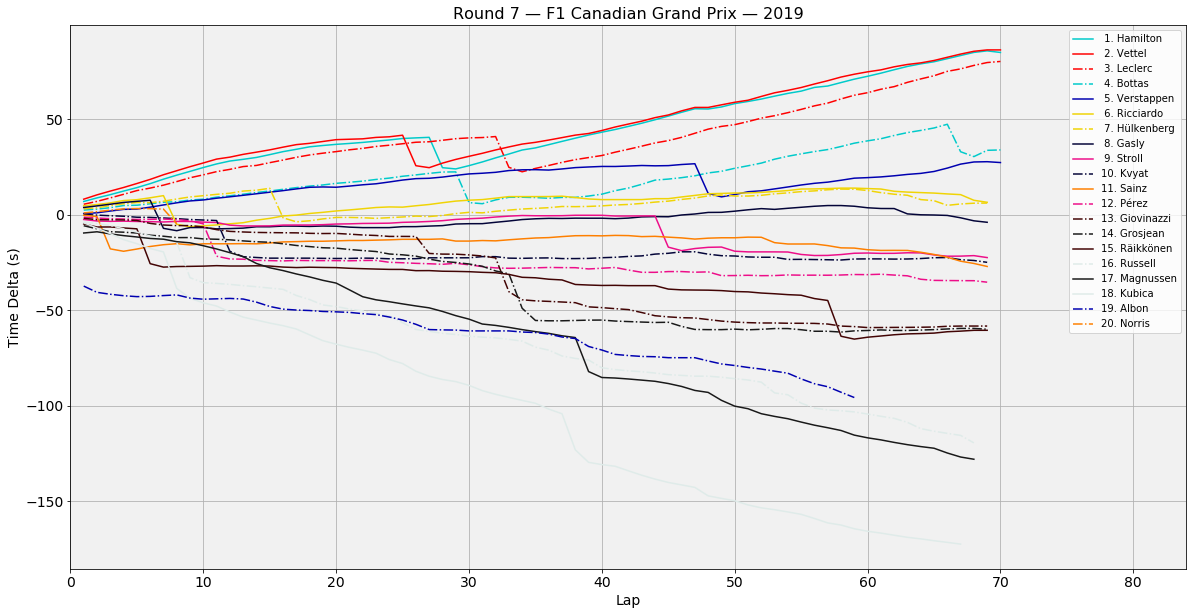

Driver          Team  Number  Grid Points  Laps  \
Position                                                                
1             Lewis Hamilton      Mercedes      44     2     25    70   
2           Sebastian Vettel       Ferrari       5     1     18    70   
3            Charles Leclerc       Ferrari      16     3     15    70   
4            Valtteri Bottas      Mercedes      77     6     13    70   
5             Max Verstappen      Red Bull      33     9     10    70   
6           Daniel Ricciardo       Renault       3     4      8    69   
7            Nico Hülkenberg       Renault      27     7      6    69   
8               Pierre Gasly      Red Bull      10     5      4    69   
9               Lance Stroll  Racing Point      18    17      2    69   
10              Daniil Kvyat    Toro Rosso      26    10      1    69   
11              Carlos Sainz       McLaren      55    11           69   
12              Sergio Pérez  Racing Point      11    15           69   
13        Antonio Giovinazzi    Alfa Romeo      99    12           69   
14           Romain Grosjean  Haas F1 Team       8    14           69   
15            Kimi Räikkönen    Alfa Romeo       7    16           69   
16            George Russell      Williams      63    18           68   
17           Kevin Magnussen  Haas F1 Team      20     0           68   
18             Robert Kubica      Williams      88    19           67   
19           Alexander Albon    Toro Rosso      23    13           59   
20              Lando Norris       McLaren       4     8            8   

                 Time            Status  
Position                                 
1         1:29:07.084          Finished  
2              +3.658          Finished  
3              +4.696          Finished  
4             +51.043          Finished  
5             +57.655          Finished  
6                  \N            +1 Lap  
7                  \N            +1 Lap  
8                  \N            +1 Lap  
9                  \N            +1 Lap  
10                 \N            +1 Lap  
11                 \N            +1 Lap  
12                 \N            +1 Lap  
13                 \N            +1 Lap  
14                 \N            +1 Lap  
15                 \N            +1 Lap  
16                 \N           +2 Laps  
17                 \N           +2 Laps  
18                 \N           +3 Laps  
19                 \N  Collision damage  
20                 \N        Suspension

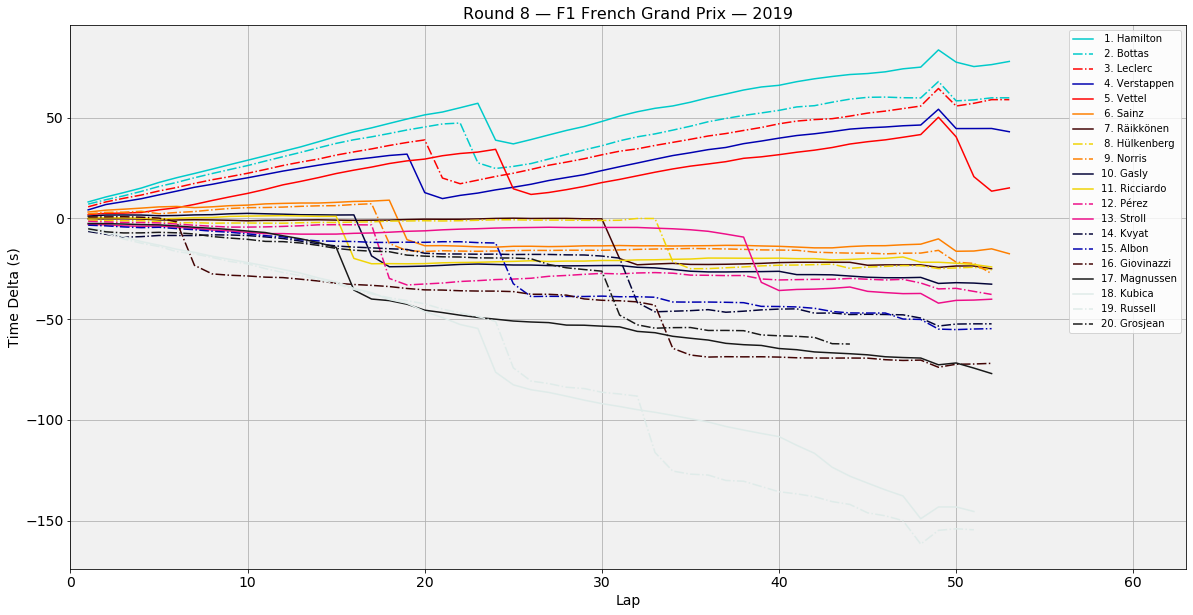

Driver          Team  Number  Grid Points  Laps  \
Position                                                                
1             Lewis Hamilton      Mercedes      44     1     25    53   
2            Valtteri Bottas      Mercedes      77     2     18    53   
3            Charles Leclerc       Ferrari      16     3     15    53   
4             Max Verstappen      Red Bull      33     4     12    53   
5           Sebastian Vettel       Ferrari       5     7     11    53   
6               Carlos Sainz       McLaren      55     6      8    53   
7             Kimi Räikkönen    Alfa Romeo       7    12      6    52   
8            Nico Hülkenberg       Renault      27    13      4    52   
9               Lando Norris       McLaren       4     5      2    52   
10              Pierre Gasly      Red Bull      10     9      1    52   
11          Daniel Ricciardo       Renault       3     8           52   
12              Sergio Pérez  Racing Point      11    14           52   
13              Lance Stroll  Racing Point      18    17           52   
14              Daniil Kvyat    Toro Rosso      26    19           52   
15           Alexander Albon    Toro Rosso      23    11           52   
16        Antonio Giovinazzi    Alfa Romeo      99    10           52   
17           Kevin Magnussen  Haas F1 Team      20    15           52   
18             Robert Kubica      Williams      88    18           51   
19            George Russell      Williams      63    20           51   
20           Romain Grosjean  Haas F1 Team       8    16           44   

                 Time    Status  
Position                         
1         1:24:31.198  Finished  
2             +18.056  Finished  
3             +18.985  Finished  
4             +34.905  Finished  
5           +1:02.796  Finished  
6           +1:35.462  Finished  
7                  \N    +1 Lap  
8                  \N    +1 Lap  
9                  \N    +1 Lap  
10                 \N    +1 Lap  
11                 \N    +1 Lap  
12                 \N    +1 Lap  
13                 \N    +1 Lap  
14                 \N    +1 Lap  
15                 \N    +1 Lap  
16                 \N    +1 Lap  
17                 \N    +1 Lap  
18                 \N   +2 Laps  
19                 \N   +2 Laps  
20                 \N   Retired

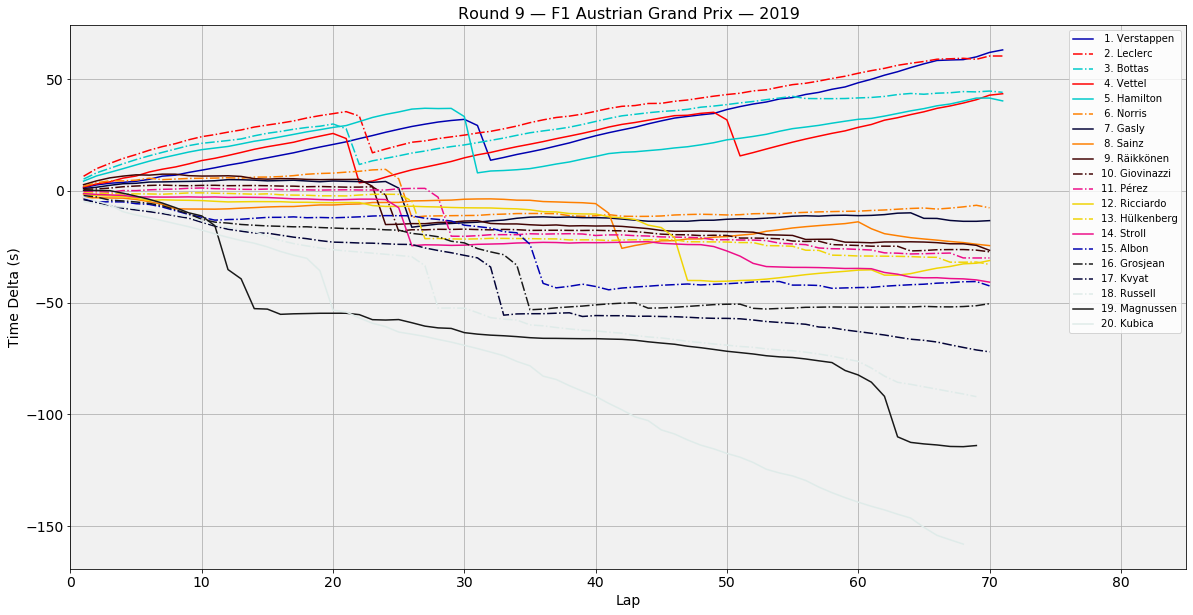

Driver          Team  Number  Grid Points  Laps  \
Position                                                                
1             Max Verstappen      Red Bull      33     2     26    71   
2            Charles Leclerc       Ferrari      16     1     18    71   
3            Valtteri Bottas      Mercedes      77     3     15    71   
4           Sebastian Vettel       Ferrari       5     9     12    71   
5             Lewis Hamilton      Mercedes      44     4     10    71   
6               Lando Norris       McLaren       4     5      8    70   
7               Pierre Gasly      Red Bull      10     8      6    70   
8               Carlos Sainz       McLaren      55    19      4    70   
9             Kimi Räikkönen    Alfa Romeo       7     6      2    70   
10        Antonio Giovinazzi    Alfa Romeo      99     7      1    70   
11              Sergio Pérez  Racing Point      11    13           70   
12          Daniel Ricciardo       Renault       3    12           70   
13           Nico Hülkenberg       Renault      27    15           70   
14              Lance Stroll  Racing Point      18    14           70   
15           Alexander Albon    Toro Rosso      23    18           70   
16           Romain Grosjean  Haas F1 Team       8    11           70   
17              Daniil Kvyat    Toro Rosso      26    16           70   
18            George Russell      Williams      63     0           69   
19           Kevin Magnussen  Haas F1 Team      20    10           69   
20             Robert Kubica      Williams      88    17           68   

                 Time    Status  
Position                         
1         1:22:01.822  Finished  
2              +2.724  Finished  
3             +18.960  Finished  
4             +19.610  Finished  
5             +22.805  Finished  
6                  \N    +1 Lap  
7                  \N    +1 Lap  
8                  \N    +1 Lap  
9                  \N    +1 Lap  
10                 \N    +1 Lap  
11                 \N    +1 Lap  
12                 \N    +1 Lap  
13                 \N    +1 Lap  
14                 \N    +1 Lap  
15                 \N    +1 Lap  
16                 \N    +1 Lap  
17                 \N    +1 Lap  
18                 \N   +2 Laps  
19                 \N   +2 Laps  
20                 \N   +3 Laps

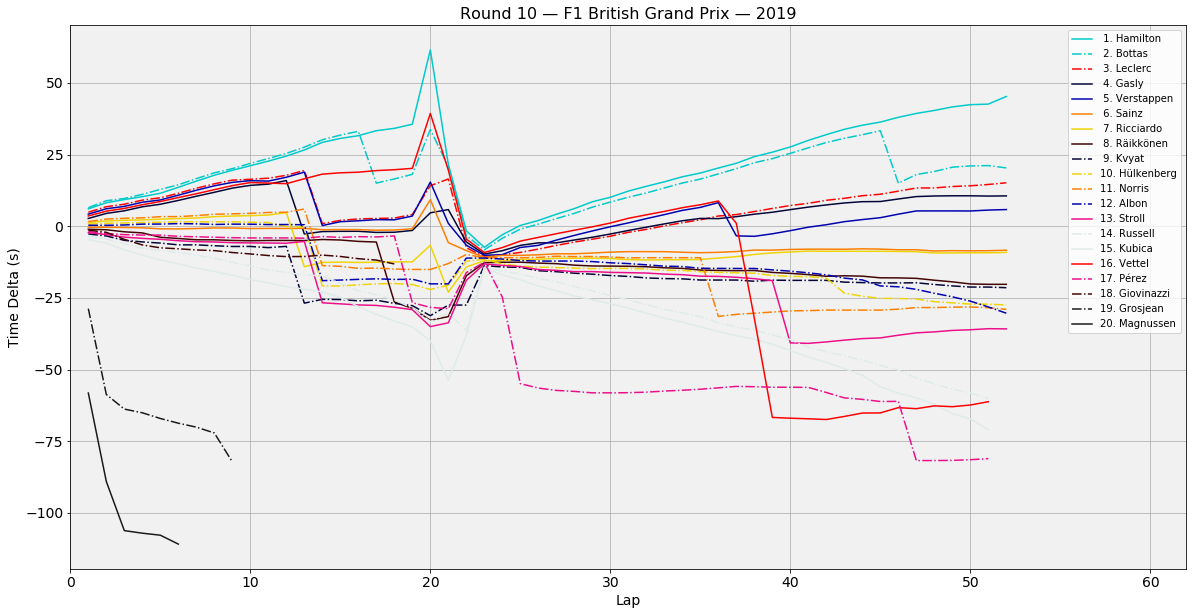

Driver          Team  Number  Grid Points  Laps  \
Position                                                                
1             Lewis Hamilton      Mercedes      44     2     26    52   
2            Valtteri Bottas      Mercedes      77     1     18    52   
3            Charles Leclerc       Ferrari      16     3     15    52   
4               Pierre Gasly      Red Bull      10     5     12    52   
5             Max Verstappen      Red Bull      33     4     10    52   
6               Carlos Sainz       McLaren      55    13      8    52   
7           Daniel Ricciardo       Renault       3     7      6    52   
8             Kimi Räikkönen    Alfa Romeo       7    12      4    52   
9               Daniil Kvyat    Toro Rosso      26    17      2    52   
10           Nico Hülkenberg       Renault      27    10      1    52   
11              Lando Norris       McLaren       4     8           52   
12           Alexander Albon    Toro Rosso      23     9           52   
13              Lance Stroll  Racing Point      18    18           52   
14            George Russell      Williams      63    19           51   
15             Robert Kubica      Williams      88    20           51   
16          Sebastian Vettel       Ferrari       5     6           51   
17              Sergio Pérez  Racing Point      11    15           51   
18        Antonio Giovinazzi    Alfa Romeo      99    11           18   
19           Romain Grosjean  Haas F1 Team       8    14            9   
20           Kevin Magnussen  Haas F1 Team      20    16            6   

                 Time     Status  
Position                          
1         1:21:08.452   Finished  
2             +24.928   Finished  
3             +30.117   Finished  
4             +34.692   Finished  
5             +39.458   Finished  
6             +53.639   Finished  
7             +54.401   Finished  
8           +1:05.540   Finished  
9           +1:06.720   Finished  
10          +1:12.733   Finished  
11          +1:14.281   Finished  
12          +1:15.617   Finished  
13          +1:21.086   Finished  
14                 \N     +1 Lap  
15                 \N     +1 Lap  
16                 \N     +1 Lap  
17                 \N     +1 Lap  
18                 \N   Spun off  
19                 \N  Collision  
20                 \N  Collision

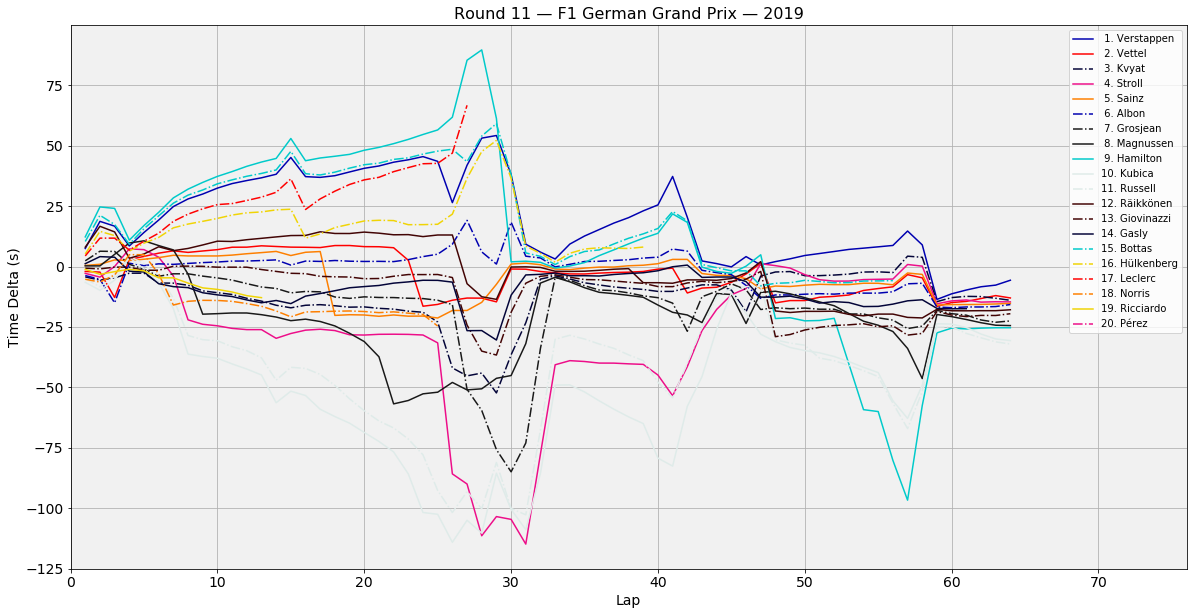

Driver          Team  Number  Grid Points  Laps  \
Position                                                                
1             Max Verstappen      Red Bull      33     2     26    64   
2           Sebastian Vettel       Ferrari       5    20     18    64   
3               Daniil Kvyat    Toro Rosso      26    14     15    64   
4               Lance Stroll  Racing Point      18    15     12    64   
5               Carlos Sainz       McLaren      55     7     10    64   
6            Alexander Albon    Toro Rosso      23    16      8    64   
7            Romain Grosjean  Haas F1 Team       8     6      6    64   
8            Kevin Magnussen  Haas F1 Team      20    12      4    64   
9             Lewis Hamilton      Mercedes      44     1      2    64   
10             Robert Kubica      Williams      88    18      1    64   
11            George Russell      Williams      63    17           64   
12            Kimi Räikkönen    Alfa Romeo       7     5           64   
13        Antonio Giovinazzi    Alfa Romeo      99    11           64   
14              Pierre Gasly      Red Bull      10     4           61   
15           Valtteri Bottas      Mercedes      77     3           56   
16           Nico Hülkenberg       Renault      27     9           39   
17           Charles Leclerc       Ferrari      16    10           27   
18              Lando Norris       McLaren       4    19           25   
19          Daniel Ricciardo       Renault       3    13           13   
20              Sergio Pérez  Racing Point      11     8            1   

                 Time      Status  
Position                           
1         1:44:31.275    Finished  
2              +7.333    Finished  
3              +8.305    Finished  
4              +8.966    Finished  
5              +9.583    Finished  
6             +10.052    Finished  
7             +16.838    Finished  
8             +18.765    Finished  
9             +19.667    Finished  
10            +24.987    Finished  
11            +26.404    Finished  
12            +42.214    Finished  
13            +43.849    Finished  
14                 \N   Collision  
15                 \N    Accident  
16                 \N    Accident  
17                 \N    Accident  
18                 \N  Power loss  
19                 \N     Exhaust  
20                 \N    Spun off

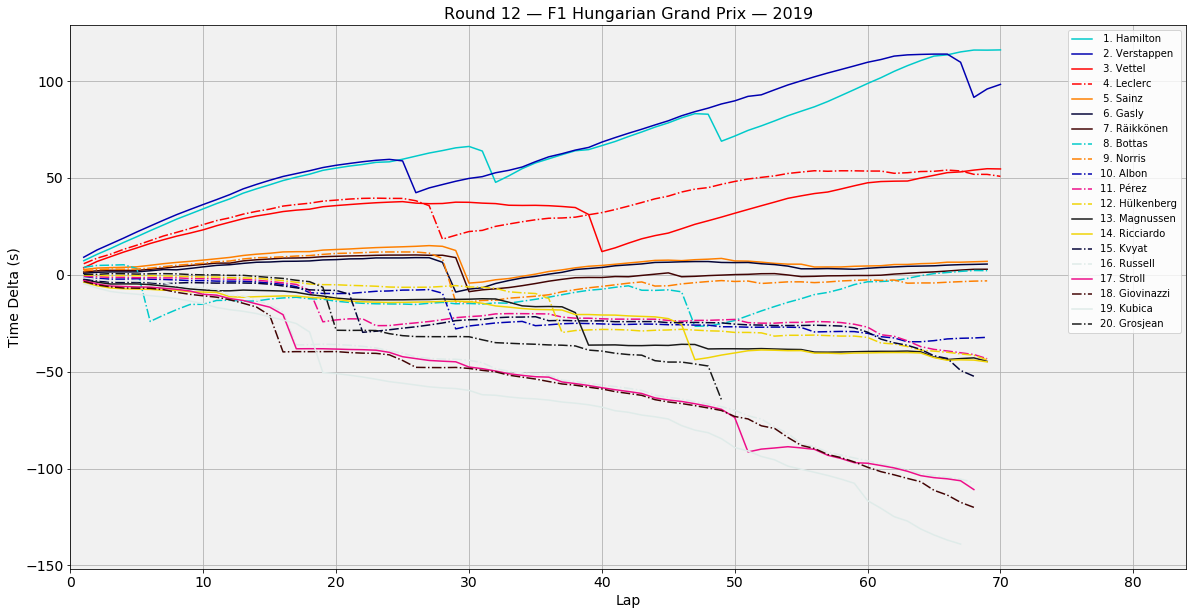

Driver          Team  Number  Grid Points  Laps  \
Position                                                                
1             Lewis Hamilton      Mercedes      44     3     25    70   
2             Max Verstappen      Red Bull      33     1     19    70   
3           Sebastian Vettel       Ferrari       5     5     15    70   
4            Charles Leclerc       Ferrari      16     4     12    70   
5               Carlos Sainz       McLaren      55     8     10    69   
6               Pierre Gasly      Red Bull      10     6      8    69   
7             Kimi Räikkönen    Alfa Romeo       7    10      6    69   
8            Valtteri Bottas      Mercedes      77     2      4    69   
9               Lando Norris       McLaren       4     7      2    69   
10           Alexander Albon    Toro Rosso      23    12      1    69   
11              Sergio Pérez  Racing Point      11    16           69   
12           Nico Hülkenberg       Renault      27    11           69   
13           Kevin Magnussen  Haas F1 Team      20    14           69   
14          Daniel Ricciardo       Renault       3    20           69   
15              Daniil Kvyat    Toro Rosso      26    13           68   
16            George Russell      Williams      63    15           68   
17              Lance Stroll  Racing Point      18    18           68   
18        Antonio Giovinazzi    Alfa Romeo      99    17           68   
19             Robert Kubica      Williams      88    19           67   
20           Romain Grosjean  Haas F1 Team       8     9           49   

                 Time          Status  
Position                               
1         1:35:03.796        Finished  
2             +17.796        Finished  
3           +1:01.433        Finished  
4           +1:05.250        Finished  
5                  \N          +1 Lap  
6                  \N          +1 Lap  
7                  \N          +1 Lap  
8                  \N          +1 Lap  
9                  \N          +1 Lap  
10                 \N          +1 Lap  
11                 \N          +1 Lap  
12                 \N          +1 Lap  
13                 \N          +1 Lap  
14                 \N          +1 Lap  
15                 \N         +2 Laps  
16                 \N         +2 Laps  
17                 \N         +2 Laps  
18                 \N         +2 Laps  
19                 \N         +3 Laps  
20                 \N  Water pressure

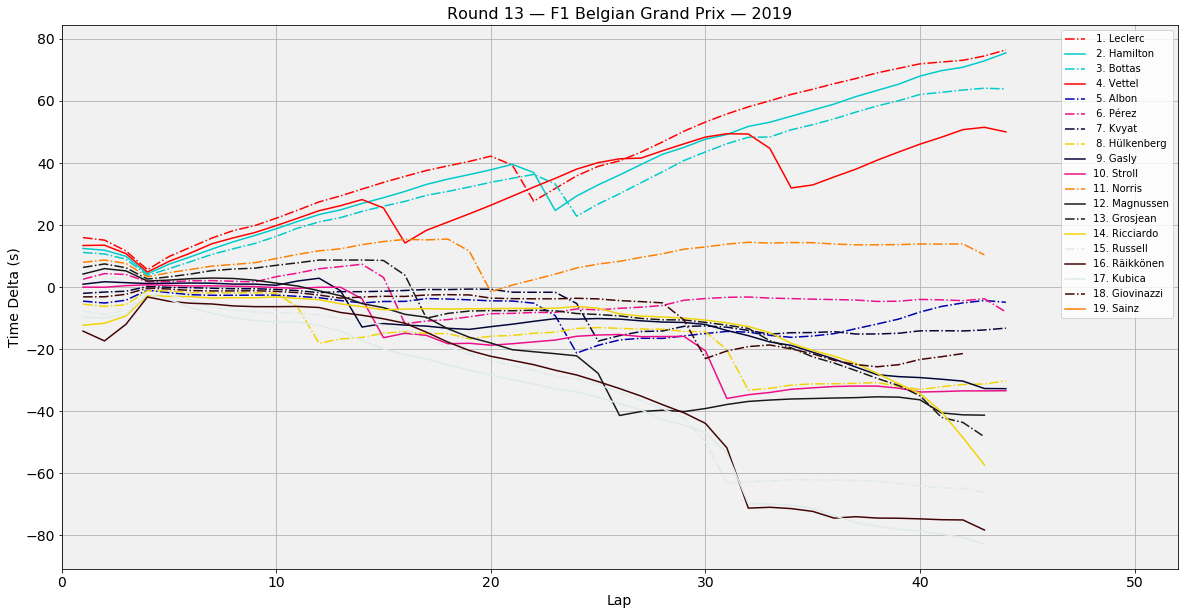

Driver          Team  Number  Grid Points  Laps  \
Position                                                                
1            Charles Leclerc       Ferrari      16     1     25    44   
2             Lewis Hamilton      Mercedes      44     3     18    44   
3            Valtteri Bottas      Mercedes      77     4     15    44   
4           Sebastian Vettel       Ferrari       5     2     13    44   
5            Alexander Albon      Red Bull      23    17     10    44   
6               Sergio Pérez  Racing Point      11     7      8    44   
7               Daniil Kvyat    Toro Rosso      26    19      6    44   
8            Nico Hülkenberg       Renault      27    12      4    44   
9               Pierre Gasly    Toro Rosso      10    13      2    44   
10              Lance Stroll  Racing Point      18    16      1    44   
11              Lando Norris       McLaren       4    11           43   
12           Kevin Magnussen  Haas F1 Team      20     8           43   
13           Romain Grosjean  Haas F1 Team       8     9           43   
14          Daniel Ricciardo       Renault       3    10           43   
15            George Russell      Williams      63    14           43   
16            Kimi Räikkönen    Alfa Romeo       7     6           43   
17             Robert Kubica      Williams      88     0           43   
18        Antonio Giovinazzi    Alfa Romeo      99    18           42   
19              Carlos Sainz       McLaren      55    15            1   
20            Max Verstappen      Red Bull      33     5            0   

                 Time      Status  
Position                           
1         1:23:45.710    Finished  
2              +0.981    Finished  
3             +12.585    Finished  
4             +26.422    Finished  
5           +1:21.325    Finished  
6           +1:24.448    Finished  
7           +1:29.657    Finished  
8           +1:46.639    Finished  
9           +1:49.168    Finished  
10          +1:49.838    Finished  
11                 \N      Engine  
12                 \N      +1 Lap  
13                 \N      +1 Lap  
14                 \N      +1 Lap  
15                 \N      +1 Lap  
16                 \N      +1 Lap  
17                 \N      +1 Lap  
18                 \N    Accident  
19                 \N  Power loss  
20                 \N    Accident

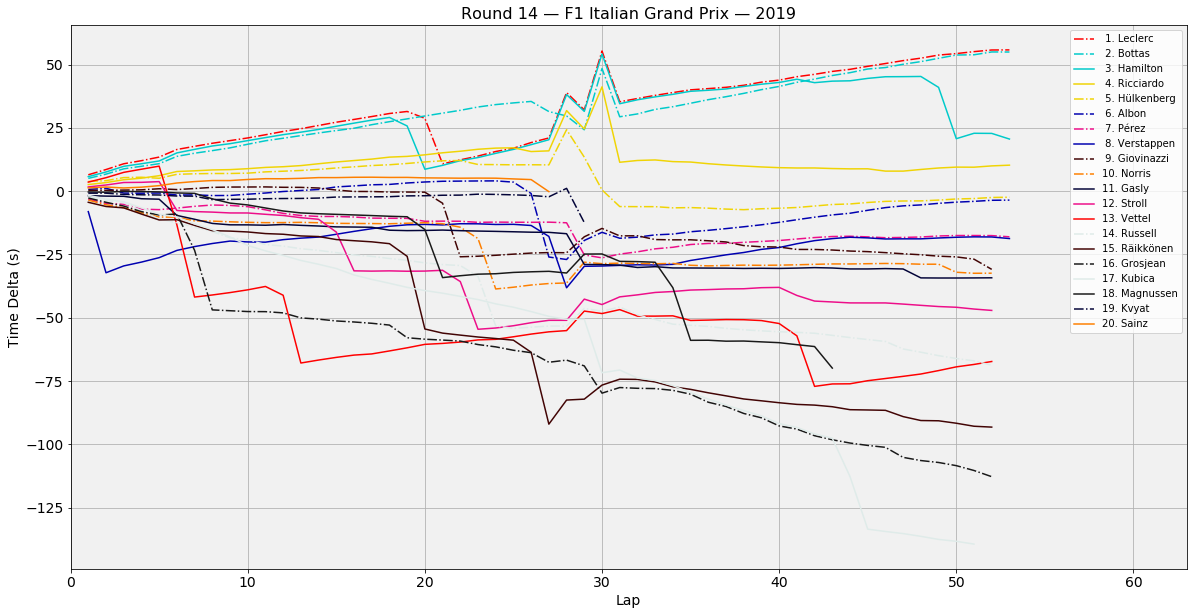

Driver          Team  Number  Grid Points  Laps  \
Position                                                                
1            Charles Leclerc       Ferrari      16     1     25    53   
2            Valtteri Bottas      Mercedes      77     3     18    53   
3             Lewis Hamilton      Mercedes      44     2     16    53   
4           Daniel Ricciardo       Renault       3     5     12    53   
5            Nico Hülkenberg       Renault      27     6     10    53   
6            Alexander Albon      Red Bull      23     8      8    53   
7               Sergio Pérez  Racing Point      11    18      6    53   
8             Max Verstappen      Red Bull      33    19      4    53   
9         Antonio Giovinazzi    Alfa Romeo      99    10      2    52   
10              Lando Norris       McLaren       4    16      1    52   
11              Pierre Gasly    Toro Rosso      10    17           52   
12              Lance Stroll  Racing Point      18     9           52   
13          Sebastian Vettel       Ferrari       5     4           52   
14            George Russell      Williams      63    14           52   
15            Kimi Räikkönen    Alfa Romeo       7     0           52   
16           Romain Grosjean  Haas F1 Team       8    13           52   
17             Robert Kubica      Williams      88    15           51   
18           Kevin Magnussen  Haas F1 Team      20    11           43   
19              Daniil Kvyat    Toro Rosso      26    12           29   
20              Carlos Sainz       McLaren      55     7           27   

                 Time      Status  
Position                           
1         1:15:26.665    Finished  
2              +0.835    Finished  
3             +35.199    Finished  
4             +45.515    Finished  
5             +58.165    Finished  
6             +59.315    Finished  
7           +1:13.802    Finished  
8           +1:14.492    Finished  
9                  \N      +1 Lap  
10                 \N      +1 Lap  
11                 \N      +1 Lap  
12                 \N      +1 Lap  
13                 \N      +1 Lap  
14                 \N      +1 Lap  
15                 \N      +1 Lap  
16                 \N      +1 Lap  
17                 \N     +2 Laps  
18                 \N  Hydraulics  
19                 \N      Engine  
20                 \N       Wheel

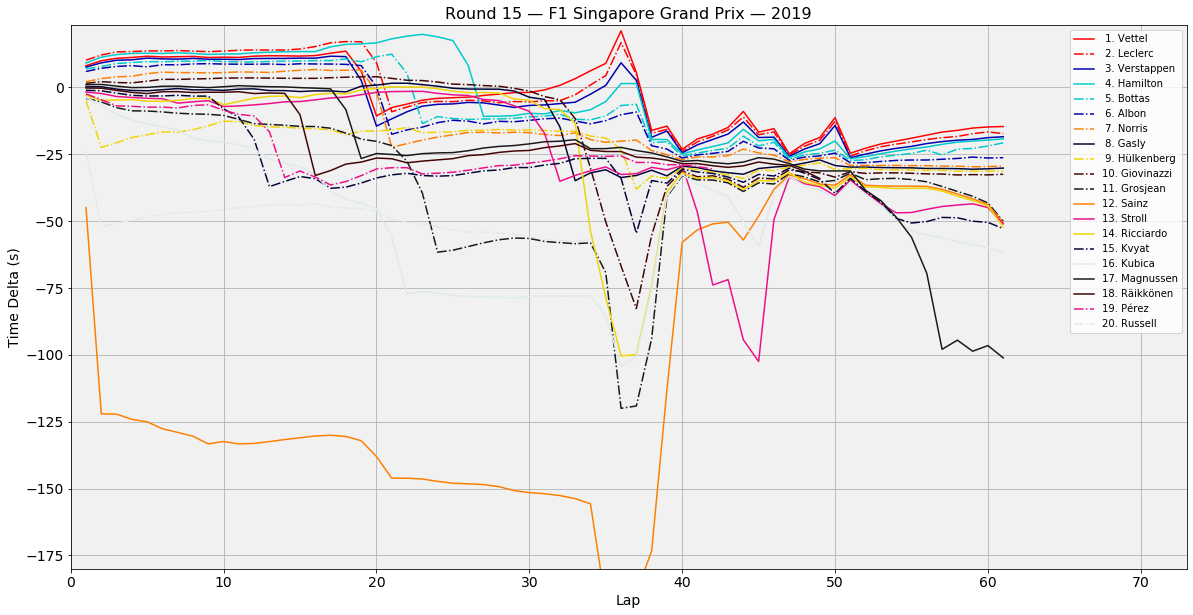

Driver          Team  Number  Grid Points  Laps  \
Position                                                                
1           Sebastian Vettel       Ferrari       5     3     25    61   
2            Charles Leclerc       Ferrari      16     1     18    61   
3             Max Verstappen      Red Bull      33     4     15    61   
4             Lewis Hamilton      Mercedes      44     2     12    61   
5            Valtteri Bottas      Mercedes      77     5     10    61   
6            Alexander Albon      Red Bull      23     6      8    61   
7               Lando Norris       McLaren       4     9      6    61   
8               Pierre Gasly    Toro Rosso      10    11      4    61   
9            Nico Hülkenberg       Renault      27     8      2    61   
10        Antonio Giovinazzi    Alfa Romeo      99    10      1    61   
11           Romain Grosjean  Haas F1 Team       8    17           61   
12              Carlos Sainz       McLaren      55     7           61   
13              Lance Stroll  Racing Point      18    16           61   
14          Daniel Ricciardo       Renault       3    20           61   
15              Daniil Kvyat    Toro Rosso      26    14           61   
16             Robert Kubica      Williams      88    19           61   
17           Kevin Magnussen  Haas F1 Team      20    13           61   
18            Kimi Räikkönen    Alfa Romeo       7    12           49   
19              Sergio Pérez  Racing Point      11    15           42   
20            George Russell      Williams      63    18           34   

                 Time     Status  
Position                          
1         1:58:33.667   Finished  
2              +2.641   Finished  
3              +3.821   Finished  
4              +4.608   Finished  
5              +6.119   Finished  
6             +11.663   Finished  
7             +14.769   Finished  
8             +15.547   Finished  
9             +16.718   Finished  
10            +27.855   Finished  
11            +35.436   Finished  
12            +35.974   Finished  
13            +36.419   Finished  
14            +37.660   Finished  
15            +38.178   Finished  
16            +47.024   Finished  
17          +1:26.522   Finished  
18                 \N  Collision  
19                 \N     Engine  
20                 \N  Collision

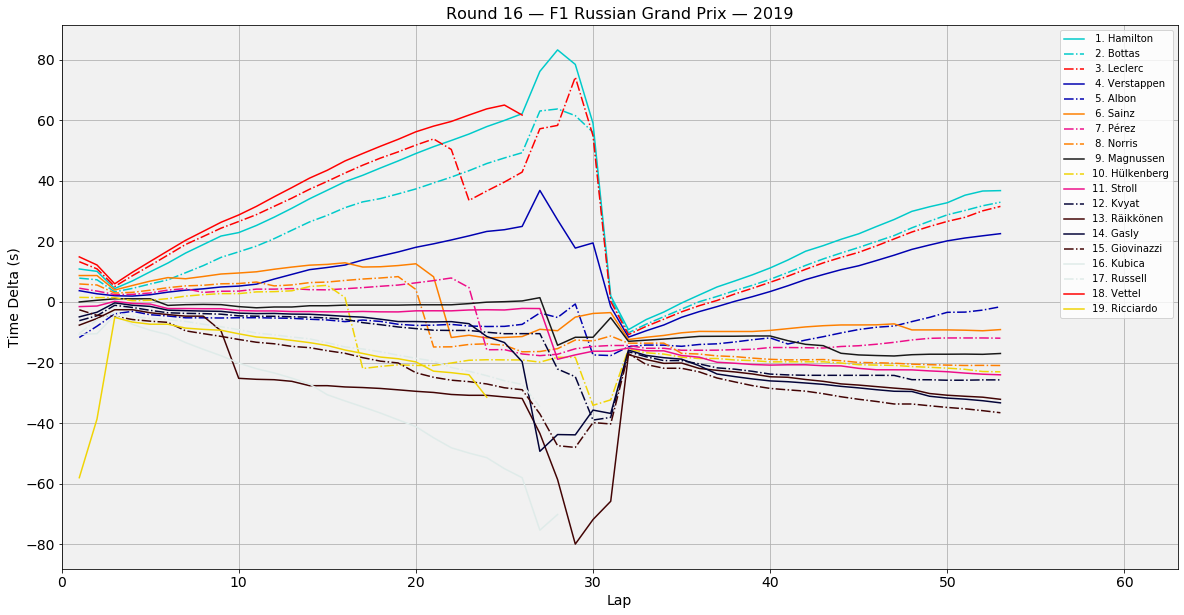

Driver          Team  Number  Grid Points  Laps  \
Position                                                                
1             Lewis Hamilton      Mercedes      44     2     26    53   
2            Valtteri Bottas      Mercedes      77     4     18    53   
3            Charles Leclerc       Ferrari      16     1     15    53   
4             Max Verstappen      Red Bull      33     9     12    53   
5            Alexander Albon      Red Bull      23     0     10    53   
6               Carlos Sainz       McLaren      55     5      8    53   
7               Sergio Pérez  Racing Point      11    11      6    53   
8               Lando Norris       McLaren       4     7      4    53   
9            Kevin Magnussen  Haas F1 Team      20    13      2    53   
10           Nico Hülkenberg       Renault      27     6      1    53   
11              Lance Stroll  Racing Point      18    14           53   
12              Daniil Kvyat    Toro Rosso      26    19           53   
13            Kimi Räikkönen    Alfa Romeo       7    15           53   
14              Pierre Gasly    Toro Rosso      10    16           53   
15        Antonio Giovinazzi    Alfa Romeo      99    12           53   
16             Robert Kubica      Williams      88    18           28   
17            George Russell      Williams      63    17           27   
18          Sebastian Vettel       Ferrari       5     3           26   
19          Daniel Ricciardo       Renault       3    10           24   
20           Romain Grosjean  Haas F1 Team       8     8            0   

                 Time      Status  
Position                           
1         1:33:38.992    Finished  
2              +3.829    Finished  
3              +5.212    Finished  
4             +14.210    Finished  
5             +38.348    Finished  
6             +45.889    Finished  
7             +48.728    Finished  
8             +57.749    Finished  
9             +58.779    Finished  
10            +59.841    Finished  
11          +1:00.821    Finished  
12          +1:02.496    Finished  
13          +1:08.910    Finished  
14          +1:10.076    Finished  
15          +1:13.346    Finished  
16                 \N      Brakes  
17                 \N      Brakes  
18                 \N  Power loss  
19                 \N   Collision  
20                 \N   Collision

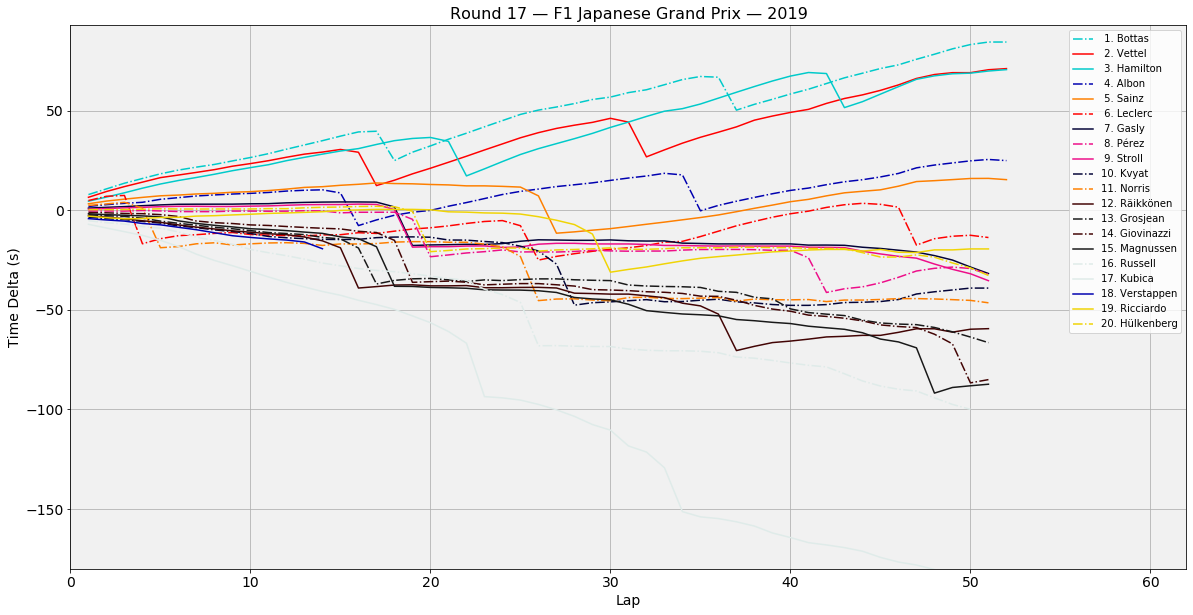

Driver          Team  Number  Grid Points  Laps  \
Position                                                                
1            Valtteri Bottas      Mercedes      77     3     25    52   
2           Sebastian Vettel       Ferrari       5     1     18    52   
3             Lewis Hamilton      Mercedes      44     4     16    52   
4            Alexander Albon      Red Bull      23     6     12    52   
5               Carlos Sainz       McLaren      55     7     10    52   
6            Charles Leclerc       Ferrari      16     2      8    51   
7               Pierre Gasly    Toro Rosso      10     9      6    51   
8               Sergio Pérez  Racing Point      11    17      4    51   
9               Lance Stroll  Racing Point      18    12      2    51   
10              Daniil Kvyat    Toro Rosso      26    14      1    51   
11              Lando Norris       McLaren       4     8           51   
12            Kimi Räikkönen    Alfa Romeo       7    13           51   
13           Romain Grosjean  Haas F1 Team       8    10           51   
14        Antonio Giovinazzi    Alfa Romeo      99    11           51   
15           Kevin Magnussen  Haas F1 Team      20    19           51   
16            George Russell      Williams      63    18           50   
17             Robert Kubica      Williams      88     0           50   
18            Max Verstappen      Red Bull      33     5           14   
19          Daniel Ricciardo       Renault       3    16           51   
20           Nico Hülkenberg       Renault      27    15           51   

                 Time        Status  
Position                             
1         1:21:46.755      Finished  
2             +13.343      Finished  
3             +13.858      Finished  
4             +59.537      Finished  
5           +1:09.101      Finished  
6                  \N        +1 Lap  
7                  \N        +1 Lap  
8                  \N        +1 Lap  
9                  \N        +1 Lap  
10                 \N        +1 Lap  
11                 \N        +1 Lap  
12                 \N        +1 Lap  
13                 \N        +1 Lap  
14                 \N        +1 Lap  
15                 \N        +1 Lap  
16                 \N       +2 Laps  
17                 \N       +2 Laps  
18                 \N        Brakes  
19                 \N  Disqualified  
20                 \N  Disqualified

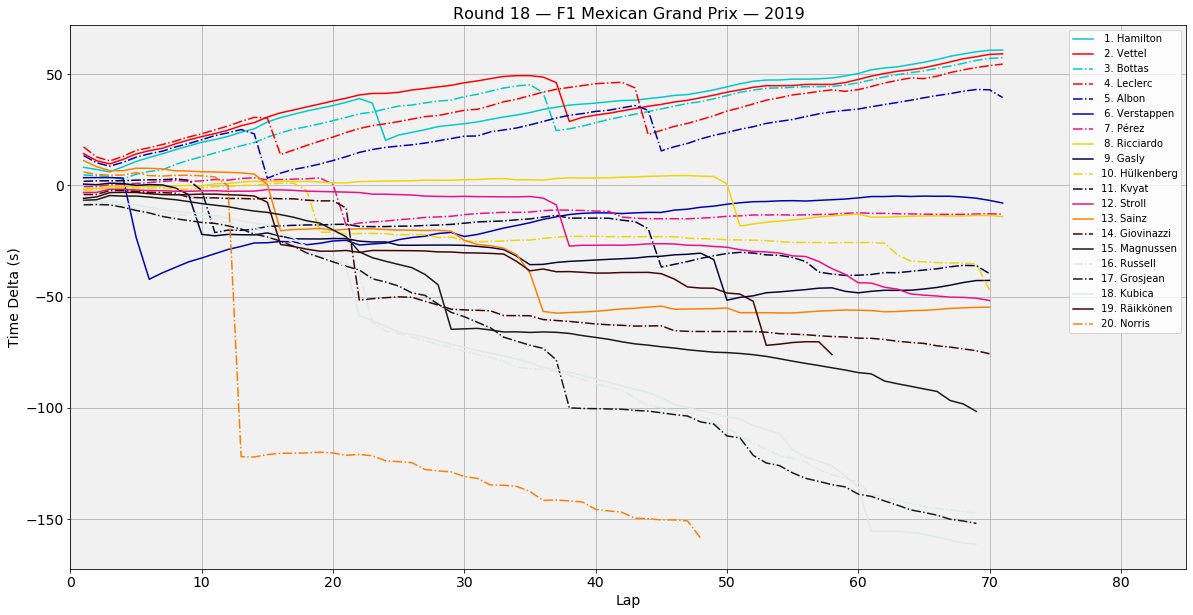

Driver          Team  Number  Grid Points  Laps  \
Position                                                                
1             Lewis Hamilton      Mercedes      44     3     25    71   
2           Sebastian Vettel       Ferrari       5     2     18    71   
3            Valtteri Bottas      Mercedes      77     6     15    71   
4            Charles Leclerc       Ferrari      16     1     13    71   
5            Alexander Albon      Red Bull      23     5     10    71   
6             Max Verstappen      Red Bull      33     4      8    71   
7               Sergio Pérez  Racing Point      11    11      6    71   
8           Daniel Ricciardo       Renault       3    13      4    71   
9               Pierre Gasly    Toro Rosso      10    10      2    70   
10           Nico Hülkenberg       Renault      27    12      1    70   
11              Daniil Kvyat    Toro Rosso      26     9           70   
12              Lance Stroll  Racing Point      18    16           70   
13              Carlos Sainz       McLaren      55     7           70   
14        Antonio Giovinazzi    Alfa Romeo      99    15           70   
15           Kevin Magnussen  Haas F1 Team      20    17           69   
16            George Russell      Williams      63    19           69   
17           Romain Grosjean  Haas F1 Team       8    18           69   
18             Robert Kubica      Williams      88    20           69   
19            Kimi Räikkönen    Alfa Romeo       7    14           58   
20              Lando Norris       McLaren       4     8           48   

                 Time       Status  
Position                            
1         1:36:48.904     Finished  
2              +1.766     Finished  
3              +3.553     Finished  
4              +6.368     Finished  
5             +21.399     Finished  
6           +1:08.807     Finished  
7           +1:13.819     Finished  
8           +1:14.924     Finished  
9                  \N       +1 Lap  
10                 \N       +1 Lap  
11                 \N       +1 Lap  
12                 \N       +1 Lap  
13                 \N       +1 Lap  
14                 \N       +1 Lap  
15                 \N      +2 Laps  
16                 \N      +2 Laps  
17                 \N      +2 Laps  
18                 \N      +2 Laps  
19                 \N  Overheating  
20                 \N     Withdrew

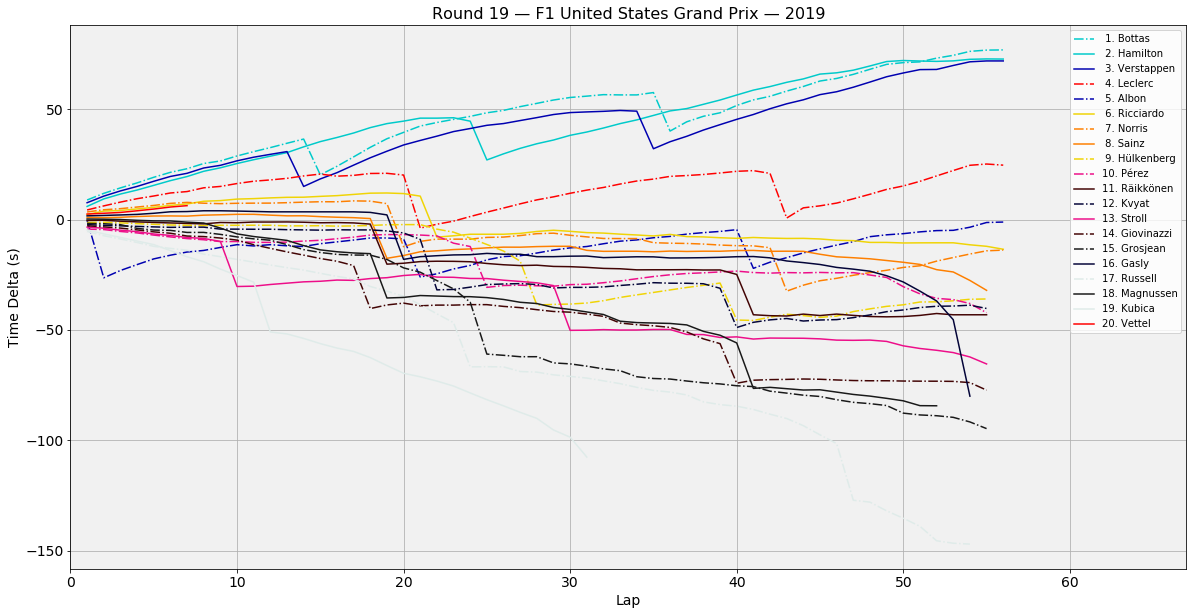

Driver          Team  Number  Grid Points  Laps  \
Position                                                                
1            Valtteri Bottas      Mercedes      77     1     25    56   
2             Lewis Hamilton      Mercedes      44     5     18    56   
3             Max Verstappen      Red Bull      33     3     15    56   
4            Charles Leclerc       Ferrari      16     4     13    56   
5            Alexander Albon      Red Bull      23     6     10    56   
6           Daniel Ricciardo       Renault       3     9      8    56   
7               Lando Norris       McLaren       4     8      6    56   
8               Carlos Sainz       McLaren      55     7      4    55   
9            Nico Hülkenberg       Renault      27    11      2    55   
10              Sergio Pérez  Racing Point      11     0      1    55   
11            Kimi Räikkönen    Alfa Romeo       7    17           55   
12              Daniil Kvyat    Toro Rosso      26    13           55   
13              Lance Stroll  Racing Point      18    14           55   
14        Antonio Giovinazzi    Alfa Romeo      99    16           55   
15           Romain Grosjean  Haas F1 Team       8    15           55   
16              Pierre Gasly    Toro Rosso      10    10           54   
17            George Russell      Williams      63    18           54   
18           Kevin Magnussen  Haas F1 Team      20    12           52   
19             Robert Kubica      Williams      88    19           31   
20          Sebastian Vettel       Ferrari       5     2            7   

                 Time      Status  
Position                           
1         1:33:55.653    Finished  
2              +4.148    Finished  
3              +5.002    Finished  
4             +52.239    Finished  
5           +1:18.038    Finished  
6           +1:30.366    Finished  
7           +1:30.764    Finished  
8                  \N      +1 Lap  
9                  \N      +1 Lap  
10                 \N      +1 Lap  
11                 \N      +1 Lap  
12                 \N      +1 Lap  
13                 \N      +1 Lap  
14                 \N      +1 Lap  
15                 \N      +1 Lap  
16                 \N  Suspension  
17                 \N     +2 Laps  
18                 \N      Brakes  
19                 \N    Oil leak  
20                 \N  Suspension

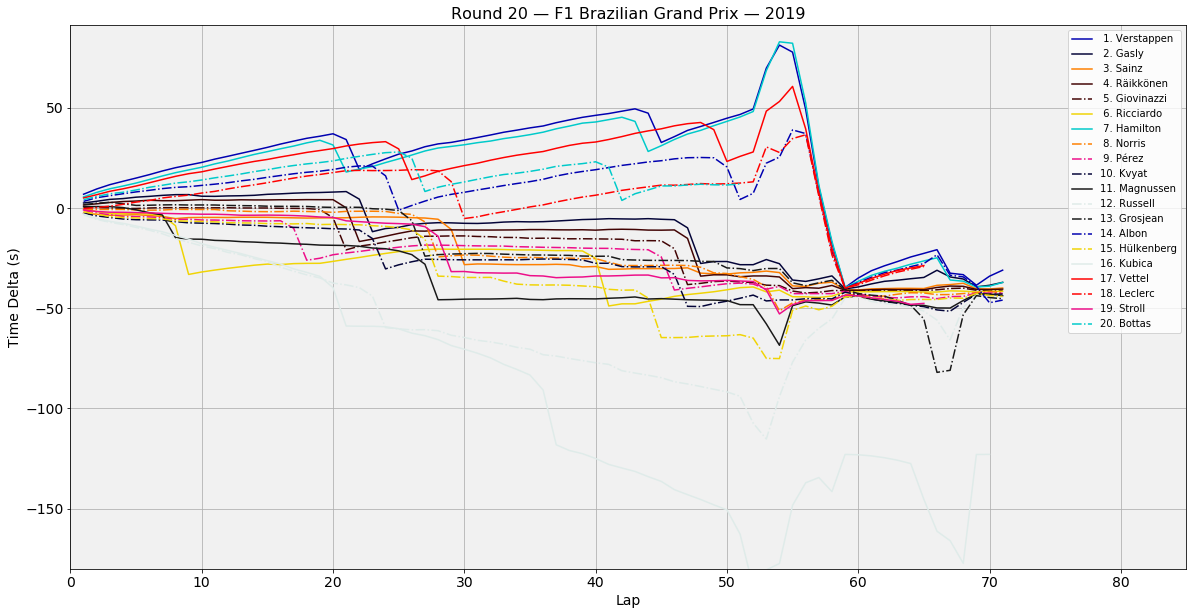

Driver          Team  Number  Grid Points  Laps  \
Position                                                                
1             Max Verstappen      Red Bull      33     1     25    71   
2               Pierre Gasly    Toro Rosso      10     6     18    71   
3               Carlos Sainz       McLaren      55    20     15    71   
4             Kimi Räikkönen    Alfa Romeo       7     8     12    71   
5         Antonio Giovinazzi    Alfa Romeo      99    12     10    71   
6           Daniel Ricciardo       Renault       3    11      8    71   
7             Lewis Hamilton      Mercedes      44     3      6    71   
8               Lando Norris       McLaren       4    10      4    71   
9               Sergio Pérez  Racing Point      11    15      2    71   
10              Daniil Kvyat    Toro Rosso      26    16      1    71   
11           Kevin Magnussen  Haas F1 Team      20     9           71   
12            George Russell      Williams      63    18           71   
13           Romain Grosjean  Haas F1 Team       8     7           71   
14           Alexander Albon      Red Bull      23     5           71   
15           Nico Hülkenberg       Renault      27    13           71   
16             Robert Kubica      Williams      88    19           70   
17          Sebastian Vettel       Ferrari       5     2           65   
18           Charles Leclerc       Ferrari      16    14           65   
19              Lance Stroll  Racing Point      18    17           65   
20           Valtteri Bottas      Mercedes      77     4           51   

                 Time      Status  
Position                           
1         1:33:14.678    Finished  
2              +6.077    Finished  
3              +8.896    Finished  
4              +9.452    Finished  
5             +10.201    Finished  
6             +10.541    Finished  
7             +11.139    Finished  
8             +11.204    Finished  
9             +11.529    Finished  
10            +11.931    Finished  
11            +12.732    Finished  
12            +13.599    Finished  
13            +14.247    Finished  
14            +14.927    Finished  
15            +18.059    Finished  
16                 \N      +1 Lap  
17                 \N   Collision  
18                 \N   Collision  
19                 \N  Suspension  
20                 \N  Power Unit

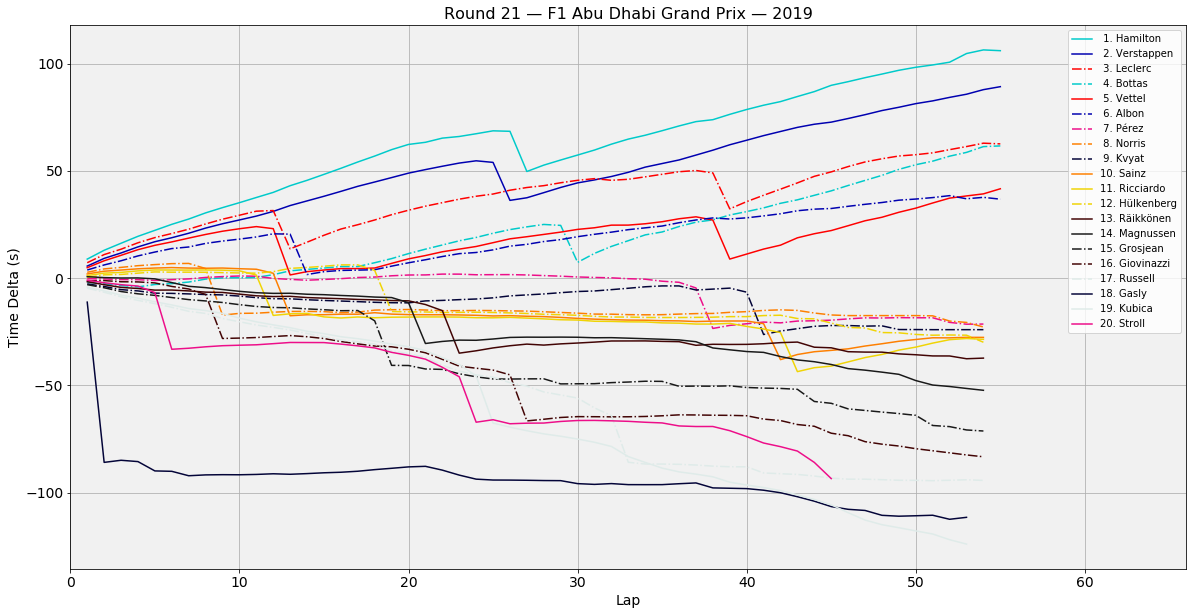

Driver          Team  Number  Grid Points  Laps  \
Position                                                                
1             Lewis Hamilton      Mercedes      44     1     26    55   
2             Max Verstappen      Red Bull      33     2     18    55   
3            Charles Leclerc       Ferrari      16     3     15    55   
4            Valtteri Bottas      Mercedes      77    20     12    55   
5           Sebastian Vettel       Ferrari       5     4     10    55   
6            Alexander Albon      Red Bull      23     5      8    55   
7               Sergio Pérez  Racing Point      11    10      6    54   
8               Lando Norris       McLaren       4     6      4    54   
9               Daniil Kvyat    Toro Rosso      26    13      2    54   
10              Carlos Sainz       McLaren      55     8      1    54   
11          Daniel Ricciardo       Renault       3     7           54   
12           Nico Hülkenberg       Renault      27     9           54   
13            Kimi Räikkönen    Alfa Romeo       7    17           54   
14           Kevin Magnussen  Haas F1 Team      20    14           54   
15           Romain Grosjean  Haas F1 Team       8    15           54   
16        Antonio Giovinazzi    Alfa Romeo      99    16           54   
17            George Russell      Williams      63    18           54   
18              Pierre Gasly    Toro Rosso      10    11           53   
19             Robert Kubica      Williams      88    19           53   
20              Lance Stroll  Racing Point      18    12           45   

                 Time    Status  
Position                         
1         1:34:05.715  Finished  
2             +16.772  Finished  
3             +43.435  Finished  
4             +44.379  Finished  
5           +1:04.357  Finished  
6           +1:09.205  Finished  
7                  \N    +1 Lap  
8                  \N    +1 Lap  
9                  \N    +1 Lap  
10                 \N    +1 Lap  
11                 \N    +1 Lap  
12                 \N    +1 Lap  
13                 \N    +1 Lap  
14                 \N    +1 Lap  
15                 \N    +1 Lap  
16                 \N    +1 Lap  
17                 \N    +1 Lap  
18                 \N   +2 Laps  
19                 \N   +2 Laps  
20                 \N    Brakes

In [60]:
# Show race traces
for rid, times in lapTimes.groupby('raceId'):

    df = times.sort_values('lap').set_index('lap')
    res = results.query('raceId==@rid').set_index('driverId')
    r2 = res.reset_index().set_index('positionOrder')
    
    df['positionOrder'] = df.driverId.map(res.positionOrder)

    summary = df.groupby('driverId').milliseconds.agg(['count','sum','mean']).sort_values(['count','sum'])
    nlaps = summary['count'].max()
    fastest = summary.loc[summary['count']==nlaps]['sum'].min()

    # reference laptime series
    ghost = df.groupby('lap').milliseconds.median().cumsum()

    race = races.loc[rid]
    circuit = circuits.loc[race.circuitId]
    title = f'Round {race["round"]} — F1 {race["name"]} — {race.year}'

    display(HTML(
        f'<h1 id="race{race["round"]}">R{race["round"]} — {race["name"]}</h1>'
        f'<p><b>{race["date"]}</b> — <a href="{race["url"]}" target="_blank">Wikipedia race report</a>'
        f'<p><b>Circuit:</b> <a href="{circuit["url"]}" target="_blank">{circuit["name"]}</a>, {circuit["location"]}, {circuit["country"]}'
    ))
    
    plt.clf()
    sers = []
    for pos, laps in df.groupby('positionOrder'):
        ser = laps.milliseconds.cumsum()
        toplot = ((ghost - ser) / 1000.0)
        toplot[toplot>1000] = np.nan    # hack for 948 - Aus 2016
        driverId = r2.loc[pos].driverId
        drv_res = drivers.loc[driverId]
        toplot.name = f'{pos:2.0f}. {drv_res.display}'
        color = DRIVER_C[driverId]
        lstyle = LINESTYLES[DRIVER_LS[driverId]]
        ax = toplot.plot(figsize=(20, 10),
                         fontsize=14,
                         grid=True,
                         color=color,
                         linestyle=lstyle,
                         legend=True,
                         xlim=(0, int(nlaps * 1.2)))
        sers.append(toplot)

    ss = pd.concat(sers, 1)
    if ss.min().min() < -180:
        plt.ylim(-180, 1.1 * ss.max().max())
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Lap', fontsize=14)
    ax.set_ylabel('Time Delta (s)', fontsize=14)
    ax.set_facecolor('#f1f1f1')
    plt.show()

    display(HTML(f'<h2>Results</h2>'))
    display(format_results(res))